# 401 Assignment 1

## 1 Tuning Hyper-parameters

In [374]:
#imports
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn import datasets, tree, linear_model
from sklearn.model_selection import train_test_split, KFold
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from matplotlib.pylab import rcParams

#settings
random.seed( 5577993311 )
rcParams['figure.figsize'] = 25,25

Several helper functions were created:
- get_average 
 - Simply returns the average result of a list
- scale_data
 - A small wrapper function for scaling data appropriately using sklearn's StandardScaler
- is_improvement
 - A function that calculates if the next iteration of the max_depth is a valid improvement. The formula requires that
  for any 1 increase in depth, there should be at least a 2% increase in accuracy.

In [375]:
# helper functions
def get_average(arr):#returns the average of a python list
    s = 0
    for a in arr:
        s = s + a
    avg = s/len(arr)
    return avg

def scale_data(xtrain, xtest):#scales data using sklearns standard scaler
    feature_scaler = StandardScaler()
    return feature_scaler.fit_transform(xtrain), feature_scaler.transform(xtest)

def is_improvement(prev_accuracy, prev_depth, current_accuracy, current_depth):
    if (prev_accuracy is 0) and (prev_depth is 0):
        return True
    prev_accuracy = prev_accuracy*100
    current_accuracy = current_accuracy*100
    accuracy_improvement = current_accuracy - prev_accuracy
    if accuracy_improvement<=0:
        return False
    depth_delta = current_depth - prev_depth
    if accuracy_improvement < depth_delta*2:
        return False
    return True
    

The run_KFold_CV method takes the training data, as well as some optional parameters relating to the k-fold itself 
with the number of splits 'n_splits' defaulting to 6.
The method works through max depths of 1 to 15.

To achieve this the method runs a for loop through each depth in which it defines a new DecisionTreeClasifier. This DT is then KFolded and each set of test and training data within the k-fold is fitted to the tree, with the accuracy and number of nodes recorded. <br/>
For each max depth this is average and used to check if the classifier is a valid improvement.
The method finally displays a dataframe and returns the best classifier.

There are also functions to test the best decision tree classifier on the test data, with different methods allowing 
for testing it without change, fitting it to all the training data and testing, along with completely remaking the 
classifier.

In [376]:
#KFold CV Method
def run_KFold_CV(x_train_kf, y_train_kf, n_splits=6, random_state = 0, shuffle = False):
    df = pd.DataFrame(columns=['Max_Tree_Depth', 'Average_Accuracy', 'Average_Node_Count'])
    depths = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    prev_avg_accuracy = 0
    prev_num_nodes = 0
    for depth in depths:
        kf_tree = tree.DecisionTreeClassifier(max_depth=depth)
        kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
        accuracy = []
        num_nodes = []
        for train_index, test_index in kf.split(x_train_kf):
            x_tr, x_te = x_train_kf[train_index], x_train_kf[test_index]
            y_tr, y_te = y_train_kf[train_index], y_train_kf[test_index]
            kf_tree = kf_tree.fit(x_tr, y_tr)
            predictions = kf_tree.predict(x_te)
            accuracy.append(kf_tree.score(x_te, y_te))
            num_nodes.append(kf_tree.tree_.node_count)
            acc_avg = get_average(accuracy)
            num_nodes_avg = get_average(num_nodes)
        df = df.append({'Max_Tree_Depth':depth, 'Average_Accuracy':acc_avg, 'Average_Node_Count': num_nodes_avg}, ignore_index=True)
        if is_improvement(prev_avg_accuracy, depth-1, acc_avg, depth):
            prev_avg_accuracy, prev_num_nodes = acc_avg, num_nodes_avg
            best_depth = depth
            best_num_nodes = num_nodes_avg
            best_tree = kf_tree
    display(df)
    print('The best classifier was found with depth: ', best_depth, ' and an average number of nodes of: ', best_num_nodes)
    return best_tree

def test_best_tree(best_tree, x_te, y_te):
    predictions = best_tree.predict(x_te)
    accuracy = best_tree.score(x_te, y_te)
    print("The best classifier achieved an accuracy of ", accuracy, " on the test data")
    return
 
def train_best_tree(best_tree, x_tr, y_tr, x_te, y_te):
    kf_tree = best_tree
    
    kf_tree.fit(x_tr, y_tr)
    
    predictions = kf_tree.predict(x_te)
    accuracy = kf_tree.score(x_te, y_te)
    print("The best classifier achieved an accuracy of ", accuracy, " on the test data when fitted again with all training data")
    return

def retrain_best_tree(best_tree, x_tr, y_tr, x_te, y_te):
    kf_tree = tree.DecisionTreeClassifier(max_depth=best_tree.max_depth)
    
    kf_tree.fit(x_tr, y_tr)
    
    predictions = kf_tree.predict(x_te)
    accuracy = kf_tree.score(x_te, y_te)
    print("The best classifier achieved an accuracy of ", accuracy, " on the test data when recreated and fitted with all training data")
    return

### Results
Below are the code and results of running the Iris, Breast caner, and Digits datasets respectively.

The code that generates the results for each section is very similar, and simply loads the dataset, splits the data into 
the expected sets and runs the run_KFold_CV method. Tables are then shown for each dataset with the best classifier 
being tested on the training data.

#### Iris plant recognition

In [377]:
# Iris plant recognition  
iris = datasets.load_iris()
iris_X = iris.data
iris_Y = iris.target
# split into train and test then scale
iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(iris_X, iris_Y, test_size=0.3, random_state=0)
iris_X_train, iris_X_test = scale_data(iris_X_train, iris_X_test)
# run kfold cv
iris_best_tree = run_KFold_CV(iris_X_train, iris_y_train)
test_best_tree(iris_best_tree, iris_X_test, iris_y_test)
#train_best_tree(iris_best_tree, iris_X_train, iris_y_train, iris_X_test, iris_y_test) #removed as result was identical
#retrain_best_tree(iris_best_tree, iris_X_train, iris_y_train, iris_X_test, iris_y_test) #removed as result was identical

,Max_Tree_Depth,Average_Accuracy,Average_Node_Count
0,1.0,0.611111,3.000000
1,2.0,0.924292,5.000000
2,3.0,0.961874,8.333333
3,4.0,0.942810,11.333333
4,5.0,0.952070,11.333333
5,6.0,0.942810,11.333333
6,7.0,0.942810,11.666667
7,8.0,0.942810,11.333333
8,9.0,0.942810,11.666667
9,10.0,0.952070,11.333333


The best classifier was found with depth:  3  and an average number of nodes of:  8.333333333333334
The best classifier achieved an accuracy of  0.9777777777777777  on the test data


#### Breast cancer diagnosis

In [378]:
# Breast cancer diagnosis
breast_cancer = datasets.load_breast_cancer()
breast_cancer_X = breast_cancer.data
breast_cancer_Y = breast_cancer.target
# split into train and test then scale
breast_cancer_X_train, breast_cancer_X_test, breast_cancer_y_train, breast_cancer_y_test = train_test_split(breast_cancer_X, breast_cancer_Y, test_size=0.3, random_state=0)
breast_cancer_X_train, breast_cancer_X_test = scale_data(breast_cancer_X_train, breast_cancer_X_test)
# run kflod cv
breast_cancer_best_tree = run_KFold_CV(breast_cancer_X_train, breast_cancer_y_train)
test_best_tree(breast_cancer_best_tree, breast_cancer_X_test, breast_cancer_y_test)

,Max_Tree_Depth,Average_Accuracy,Average_Node_Count
0,1.0,0.909543,3.000000
1,2.0,0.907131,7.000000
2,3.0,0.927220,14.000000
3,4.0,0.924619,21.333333
4,5.0,0.917157,27.000000
5,6.0,0.927182,29.000000
6,7.0,0.919607,29.666667
7,8.0,0.912106,30.333333
8,9.0,0.909694,30.333333
9,10.0,0.907169,30.333333


The best classifier was found with depth:  1  and an average number of nodes of:  3.0
The best classifier achieved an accuracy of  0.8947368421052632  on the test data


#### Digit Recognition

In [379]:
# Digit recognition
# manipulate data into (samples, feature) matrix
digits = datasets.load_digits()
digits_n_samples = len(digits.images)
digits_X = digits.images.reshape((digits_n_samples), -1)
digits_y = digits.target
# split into train and test then scale
digits_X_train, digits_X_test, digits_y_train, digits_y_test = train_test_split(digits_X, digits_y, test_size=0.3, random_state=0)
digits_X_train, digits_X_test = scale_data(digits_X_train, digits_X_test)
# run kflod cv
digits_best_tree = run_KFold_CV(digits_X_train, digits_y_train)
test_best_tree(digits_best_tree, digits_X_test, digits_y_test)


,Max_Tree_Depth,Average_Accuracy,Average_Node_Count
0,1.0,0.189333,3.000000
1,2.0,0.316648,7.000000
2,3.0,0.460652,15.000000
3,4.0,0.640389,30.333333
4,5.0,0.706429,53.666667
5,6.0,0.776441,84.333333
6,7.0,0.822606,125.333333
7,8.0,0.825792,166.333333
8,9.0,0.832149,199.666667
9,10.0,0.840913,220.000000


The best classifier was found with depth:  7  and an average number of nodes of:  125.33333333333333
The best classifier achieved an accuracy of  0.8240740740740741  on the test data


## 2 Decision trees vs linear models

#### Formula
The formula used for the problem was y > x. That is for any data point if the y-value is greater than the x-value it is 
considered in the positive class. Consequently any data point with  y <= x will be considered in the negative class.

To create a data set there are several helper functions below, that randomly generate a dataset of a specified size, 
consisting of a roughly 50/50 split between the positive and negative class.

It should noted that the difficulty for a decision tree classifier requires that the difference between values in the 
negative and positive class are close. This is because the decision tree relies on boundaries of these values, so a 
larger difference means less boundaries would be needed to better model the datapoints.

In [380]:
#Constructing the problem
def my_problem(x):
    return x,x*(1+random.randint(1,5)/250)
    #return x,2*x

def get_random_fail(x):
    return x, x*(1-random.randint(1,5)/250)
    #return x, x*0.5

def create_dataset(n=100):
    dataset_x = []
    dataset_y = []
    for i in range(1,n):
        if random.randint(0,10) % 2 == 0:
            dataset_x.append(my_problem(i))
            dataset_y.append(1)
        else:
            dataset_x.append(get_random_fail(i))
            dataset_y.append(0)
    return dataset_x, dataset_y

The testing of linear and decision tree classifications was done at different dataset sizes and max depths (for the
decision tree). The dataset sizes varied from 50 to 450 in steps of 100, while the max depths were all integers 1 to 12
inclusive. 

In [381]:
ldf = pd.DataFrame(columns=['Dataset Size', 'Score'])
tdf = pd.DataFrame(columns=['Dataset Size', 'Max Depth', 'Score'])
for k in range(50, 451, 100):
    x,y = create_dataset(k)
    #print('dataset of size: ',k, ' -- ',list(zip(x,y)))
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
    linear = linear_model.LogisticRegression(random_state=0, solver='lbfgs')
    linear.fit(x_train, y_train)
    linear_predict = list(linear.predict(x_test))
    #l_accuracy = accuracy_score(y_test, linear_predict)
    l_score = linear.score(x_test, y_test)
    ldf = ldf.append({'Dataset Size':k, 'Score':l_score}, ignore_index=True)
    for l in range(1,12):
        d_tree = tree.DecisionTreeClassifier(max_depth=l, random_state=0)
        d_tree = d_tree.fit(x_train, y_train)
        d_tree_predict = d_tree.predict(x_test)
        #d_tree_accuracy = accuracy_score(y_test, d_tree_predict)
        score = d_tree.score(x_test, y_test)
        tdf = tdf.append({'Dataset Size':k, 'Max Depth':l,'Score':score}, ignore_index=True)

In [382]:
print('Accuracy of linear regression across multiple dataset sizes using LMBFGS optimisation algorithm')
display(ldf)

Accuracy of linear regression across multiple dataset sizes using LMBFGS optimisation algorithm


,Dataset Size,Score
0,50.0,1.000000
1,150.0,0.977778
2,250.0,1.000000
3,350.0,0.971429
4,450.0,0.977778


In [383]:
print('Accuracy of decision tree classifier across multiple dataset sizes and max depths')
display(tdf)

Accuracy of decision tree classifier across multiple dataset sizes and max depths


,Dataset Size,Max Depth,Score
0,50.0,1.0,0.600000
1,50.0,2.0,0.533333
2,50.0,3.0,0.600000
3,50.0,4.0,0.533333
4,50.0,5.0,0.533333
5,50.0,6.0,0.533333
6,50.0,7.0,0.533333
7,50.0,8.0,0.533333
8,50.0,9.0,0.533333
9,50.0,10.0,0.466667


### Discussion of table results
It can be seen that the linear model performs far superior, getting a perfect score with several of the datasets, and
the others being very high. Conversely the decision tree fluctuates between 0.4 and 0.7, with little clear correlation
between the score and dataset size or max depth.


DecisionTreeClassifier on dataset size  50  with max_depth =  4  and score =  0.26666666666666666
The graph below plots the datapoints (black) against the line y=x (yellow) which 
separates the positive and negative classes, along with the decision boundary of the classifier.


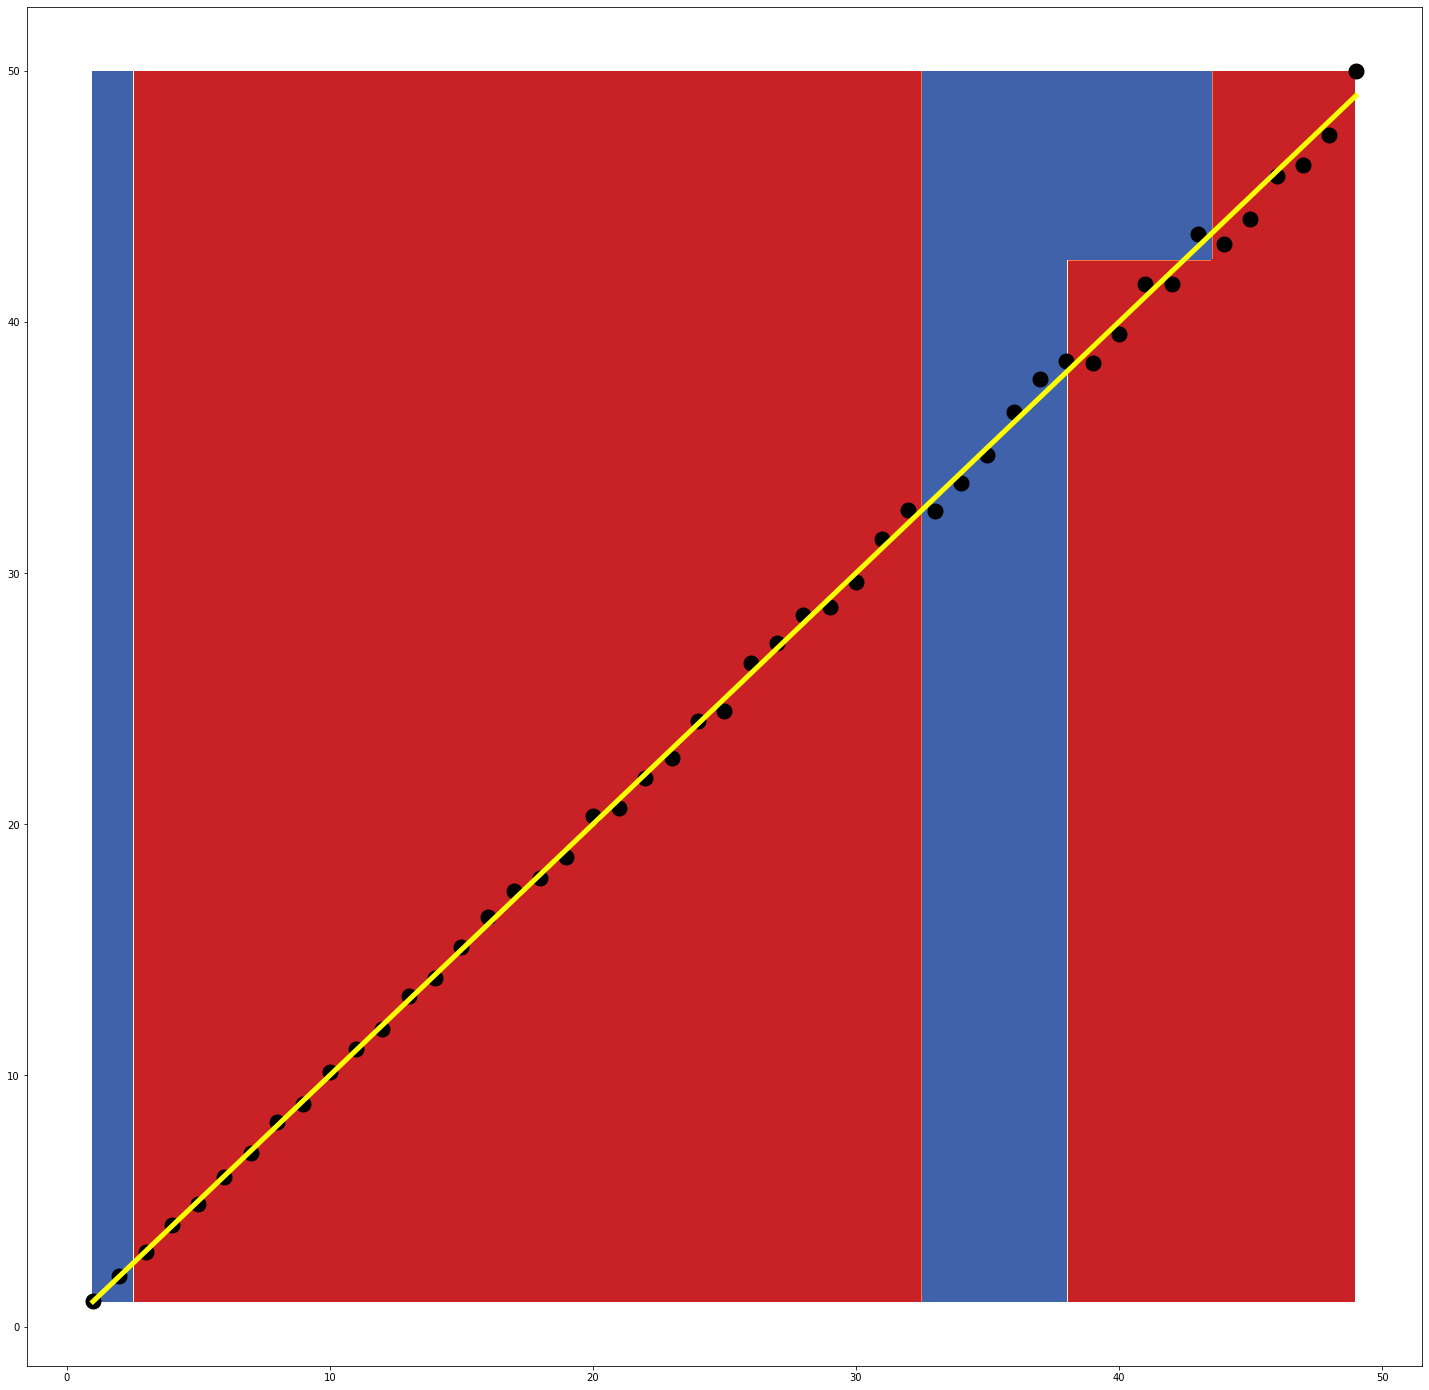

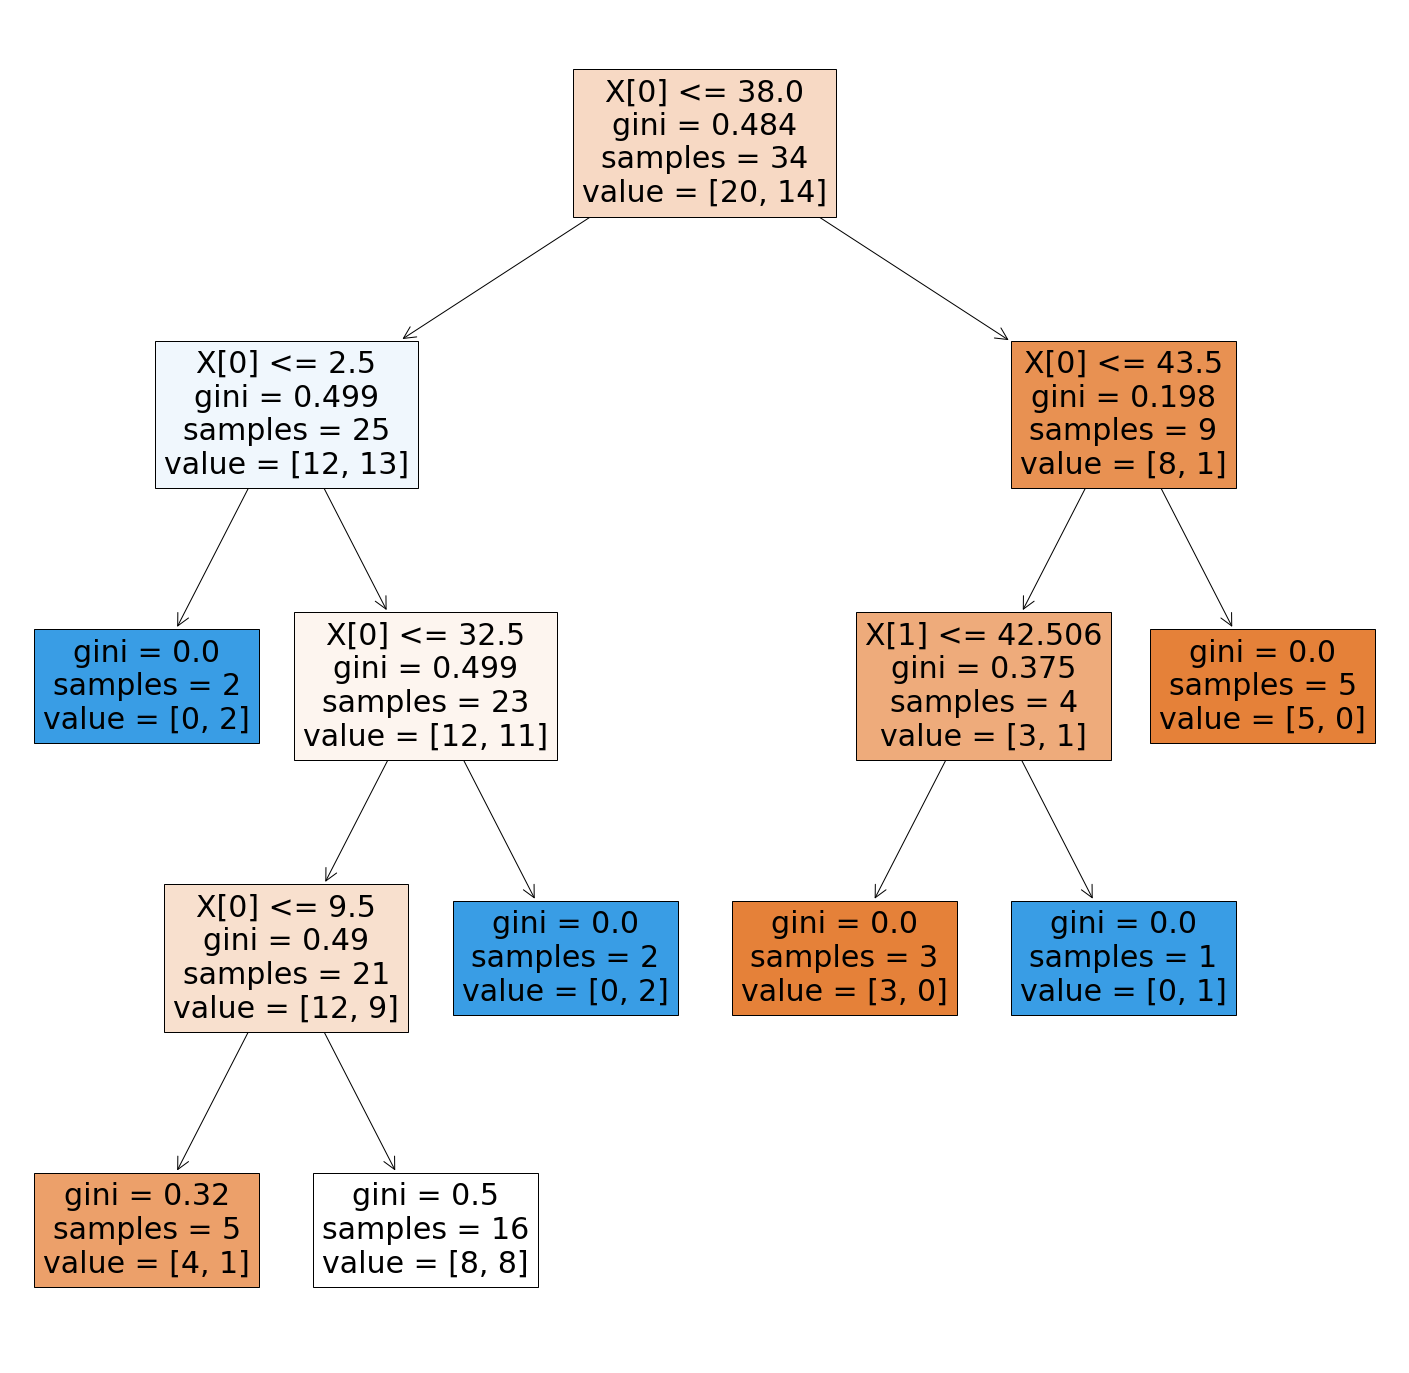

In [384]:
d_size = 50
m_d = 4
x, y = create_dataset(d_size)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
d_tree = tree.DecisionTreeClassifier(max_depth=m_d)
d_tree = d_tree.fit(x_train, y_train)
d_tree_predict = d_tree.predict(x_test)
#d_tree_accuracy = accuracy_score(y_test, d_tree_predict)
score = d_tree.score(x_test, y_test)
print('DecisionTreeClassifier on dataset size ',d_size, ' with max_depth = ',m_d ,' and score = ', score)
# PLOT THE DTREE BOUNDARY
# Code adjusted from https://scikit-learn.org/0.15/auto_examples/tree/plot_iris.html
plot_step = 0.05
x_min, x_max = min([a for a,_ in x]), max([a for a,_ in x])
y_min, y_max = min([a for _,a in x]), max([a for _,a in x])
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
np.arange(y_min, y_max, plot_step))
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
Z = d_tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

#Plot points
print('The graph below plots the datapoints (black) against the line y=x (yellow) which \n'
      'separates the positive and negative classes, along with the decision boundary of the classifier.')
i = range(1,d_size)
plt.scatter([a for a,_ in x], [a for _,a in x], color='black', linewidths=10 )
plt.plot(i,i, color='yellow', linewidth=5)
plt.xticks()
plt.yticks()
plt.figure()
plot_tree(d_tree, filled=True, fontsize=30)
plt.show()



### Discussion of Decision Tree Graphics
The plot showing the decision boundary of the decision tree classifier shows some clear characteristics. Notably the 
decision boundaries encompass rectangular regions. This is due to how a decision tree classifier will separate the 
decision space by one dimension at a time.

The tree graphic shows the decisions made at each node and is created using the plot_tree function provided by 
sklearn.

### Implications for R<sup>d</sup>
The situation above details a problem in R<sup>2</sup>, however when looking at R<sup>d</sup> when d (the dimension of 
the problem) increases it becomes more complex for both classifiers. However a linear logistic regression will still be
able to easily classify the data using only a linear increase in complexity. However a decision tree will increase in
complexity exponentially, this is because the tree makes decisions based on one dimension at a time, thus for each
decision made in a dimension more decisions will need to be made for other dimensions.

## 3 Regression on mixed data types

### Using Separate Linear Regressions
The problem of a categorical feature with more than two levels can be solved by creating a linear regression for
each possible value of that feature. In this case A, B and C.

The models created from these then give the case based functions for their respective X4 value.

In [385]:
def linear_regression_split(reg_x, reg_y, val):#run linear regression on individual categorical feature
    csv_linear = linear_model.LinearRegression()
    csv_linear = csv_linear.fit(reg_x, reg_y)
    coeff = list(csv_linear.coef_[0])
    print('Linear Regression Results c =',val,': ')
    #print(' - intercept: ', csv_linear.intercept_[0])
    #print(' - coefficients: ', coeff)
    print(' - rounded coefficients: ', list(round(x) for x in csv_linear.coef_[0]))
    
    csv_pred = csv_linear.predict(reg_x)
    print(' - mean square error (MSE): ', mean_squared_error(reg_y, csv_pred))
    print(' - R-squared (R\u00b2): ', r2_score(reg_y, csv_pred))
    
    #print('eqtn:')
    #print(coeff[0],'x1 + ', coeff[1], 'x2 + ', coeff[2], 'x3 + ', csv_linear.intercept_[0],', c = ', val)
    return str(coeff[0])+'*x1 + '+ str(coeff[1])+ '*x2 + '+ str(coeff[2]) + '*x3 + '+ str(csv_linear.intercept_[0])+', c = '+ str(val)

#load csv file
csv_pf = pd.read_csv('assignment1-2019-data.csv')

# split data based on categorical feature
csv_XA = csv_pf.loc[csv_pf['X4'] == 'A']
csv_XA_X = [tuple(x) for x in csv_XA[['X1', 'X2', 'X3']].values]
csv_XA_Y = [tuple(x) for x in csv_XA[['Y']].values]

csv_XB = csv_pf.loc[csv_pf['X4'] == 'B']
csv_XB_X = [tuple(x) for x in csv_XB[['X1', 'X2', 'X3']].values]
csv_XB_Y = [tuple(x) for x in csv_XB[['Y']].values]

csv_XC = csv_pf.loc[csv_pf['X4'] == 'C']
csv_XC_X = [tuple(x) for x in csv_XC[['X1', 'X2', 'X3']].values]
csv_XC_Y = [tuple(x) for x in csv_XC[['Y']].values]

eqtn_a = linear_regression_split(csv_XA_X, csv_XA_Y,'A')
eqtn_b = linear_regression_split(csv_XB_X, csv_XB_Y,'B')
eqtn_c = linear_regression_split(csv_XC_X, csv_XC_Y,'C')

Linear Regression Results c = A : 
 - rounded coefficients:  [4.0, 1.0, 3.0]
 - mean square error (MSE):  6.241828284353595
 - R-squared (R²):  0.9317291799709675
Linear Regression Results c = B : 
 - rounded coefficients:  [2.0, -0.0, 1.0]
 - mean square error (MSE):  4.435902391321278
 - R-squared (R²):  0.7266989189815116
Linear Regression Results c = C : 
 - rounded coefficients:  [-3.0, 7.0, 3.0]
 - mean square error (MSE):  9.423007325818572
 - R-squared (R²):  0.9574198880262368


#### Case based definition of functions using several linear regression models

In [386]:
print('Case Based Definition of Functions:')
print(eqtn_a)
print(eqtn_b)
print(eqtn_c)

Case Based Definition of Functions:
3.792788358988609*x1 + 0.9731810697979548*x2 + 2.941036928551541*x3 + 3.0439796107019106, c = A
1.8319634209328515*x1 + -0.013862109743909001*x2 + 0.9909382401564215*x3 + 8.586293105094992, c = B
-2.8258667051239486*x1 + 6.814655842431422*x2 + 2.9833921943020023*x3 + 11.665720826185227, c = C


The rounded coefficients, mean square error and R-squared values are shown for all linear regression cases.

The linear model identified case based functions for each possible value for X4, that is our categorical feature with
more than two variables. The equation is shown above.

#### Assigning a predicted value
A predicted value can be given to any input vector of size 4 using the above case-based function. The function to use
is determined by the x4 value of the unseen data point, the predicted value can then be assigned by substituting the 
values x1, x2, x3 in the equation and solving to give y.

#####  Aside: Fixing Categorical Feature
The categorical feature which takes the value A, B, or C can also be handled using one hot encoding, where each possible 
value becomes a new boolean column, however one of these values is considered a 'baseline'. The baseline value will not
receive its own column (instead it is inferred). Pandas provides an easy method 'get_dummies' to make this simple.

In [387]:
# applying one hot encoding
# Code adjusted from https://stackoverflow.com/questions/34007308/linear-regression-analysis-with-string-categorical-features-variables
csv_pf_dummy = pd.get_dummies(csv_pf.X4)
csv_pf = csv_pf.join(csv_pf_dummy)
# display(csv_pf)
subset_X = csv_pf[['X1', 'X2', 'X3','A', 'B']] # C column is ignored as basline
csv_X = [tuple(x) for x in subset_X.values]
subset_Y = csv_pf[['Y']]
csv_Y = [tuple(x) for x in subset_Y.values]

csv_linear = linear_model.LinearRegression()
csv_linear = csv_linear.fit(csv_X, csv_Y)
coeff = list(csv_linear.coef_[0])
intercept = csv_linear.intercept_[0]
print('Linear Regression Results using one hot encoding: ')
#print(' - intercept: ', intercept)
print(' - rounded coefficients: ', list(round(x) for x in csv_linear.coef_[0]))
csv_pred = csv_linear.predict(csv_X)
print(' - mean square error (MSE): ', mean_squared_error(csv_Y, csv_pred))
print(' - R-squared (R\u00b2): ', r2_score(csv_Y, csv_pred))

Linear Regression Results using one hot encoding: 
 - rounded coefficients:  [1.0, 3.0, 2.0, 11.0, -4.0]
 - mean square error (MSE):  51.178608246662264
 - R-squared (R²):  0.6554272705683302
